# 프로젝트 : 폐렴 진단기 성능개선

모델이 X-ray 사진을 보고 정상인지 폐렴인지 분류해줍니다.  

정답이 주어진 지도 학습이지만, 이미지가 주어져 있기에 구분하는 방법을 간단하게 소개하겠습니다.  
정상적인 폐인 경우에 폐에 공기가 들어있기 때문에 X-ray의 폐부분은 어둡게 나타납니다.  
반면 폐렴 환자의 경우 폐 부위에 피와 고름 등이 차 있으면 X-ray 투과율이 떨어지므로 뿌연 음영이 관찰됩니다.

흉부 X-ray 사진은 아래에서 다운로드 받을 수 있습니다.  
[Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

### [루브릭]
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
    - 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.


2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
    - regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.


3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
    - Accuracy 기준 85%에 도달하였다.


### [학습 과정]
1. 실험환경 Set-up
2. 데이터 준비하기
3. 데이터 시각화
4. CNN 모델링
5. 데이터 imbalance 처리
6. 모델 훈련
7. 결과 확인과 시각화


### [결론 및 회고]

---

## Step 1. 실험환경 Set-up

In [1]:
import re                                               # 정규표현식 관련 패키지
import os                                               # I/O 관련 패키지 
import pandas as pd                                     # 데이터 전처리 관련 패키지
import numpy as np                                      # 데이터 array 관련 패키지
import tensorflow as tf                                 # 딥러닝 패키지
import matplotlib.pyplot as plt                         # 데이터 시각화패키지
from sklearn.model_selection import train_test_split
import random, math

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('훈련 데이터 갯수: {}'.format(len(train_filenames)))
print('테스트 데이터 갯수: {}'.format(len(test_filenames)))
print('검증 데이터 갯수: {}'.format(len(val_filenames)))

훈련 데이터 갯수: 5216
테스트 데이터 갯수: 624
검증 데이터 갯수: 16


- train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.  
- 개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.  
- train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.  

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('훈련 데이터 갯수: {}'.format(len(train_filenames)))
print('검증 데이터 갯수: {}'.format(len(val_filenames)))

훈련 데이터 갯수: 4185
검증 데이터 갯수: 1047


In [5]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


- 결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

- tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 현재 이미지에는 라벨 데이터가 따로 없습니다.
- 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
# 테스트 데이터도 동일한 작업을 해줍니다.
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print('테스트 데이터 갯수: {}'.format(TEST_IMAGE_COUNT))

테스트 데이터 갯수: 624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

- Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.

- prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줍니다.

- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
- 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
- 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

## Step 3. 데이터 시각화

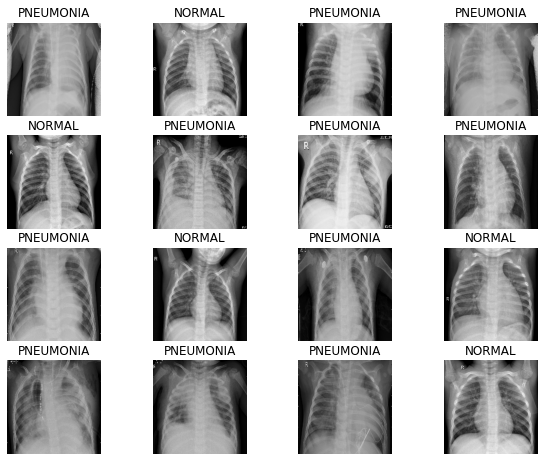

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


- 이 예의 앞부분에서 정상보다 폐렴으로 분류된 이미지가 더 많아 데이터가 불균형한 것을 보았습니다.
- 클래스 0(정상)의 가중치는 클래스 1(폐렴)의 가중치보다 훨씬 높습니다 .
- 정규 이미지가 적기 때문이며, CNN은 훈련 데이터가 균형을 이룰 때 가장 잘 작동하므로, 각 정상 이미지는 데이터 균형을 위해 더 많은 가중치를 부여합니다.

## Step 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 64s 195ms/step - loss: 0.4276 - accuracy: 0.7931 - precision: 0.9448 - recall: 0.7666 - val_loss: 0.6855 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 51s 195ms/step - loss: 0.2853 - accuracy: 0.8829 - precision: 0.9695 - recall: 0.8700 - val_loss: 0.9492 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 51s 195ms/step - loss: 0.2544 - accuracy: 0.8973 - precision: 0.9731 - recall: 0.8863 - val_loss: 0.3153 - val_accuracy: 0.8029 - val_precision: 0.7887 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 51s 196ms/step - loss: 0.2108 - accuracy: 0.9167 - precision: 0.9755 - recall: 0.9109 - val_loss: 0.2092 - val_accuracy: 0.9106 - val_precision: 0.8916 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 53s 203ms/step - loss: 0.1856 - accura

## Step 7. 결과 확인과 시각화

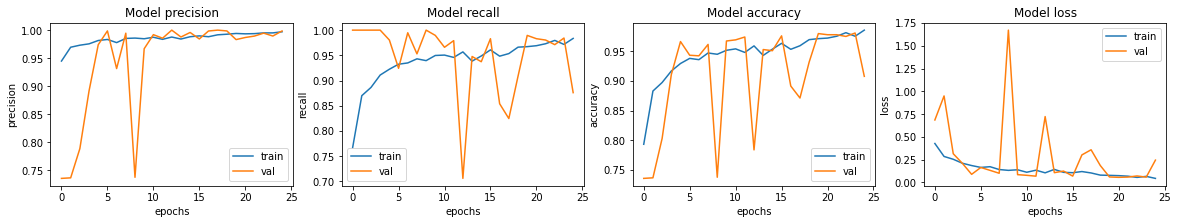

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 113ms/step - loss: 0.9190 - accuracy: 0.7997 - precision: 0.7887 - recall: 0.9282
Loss: 0.91902756690979,
Accuracy: 0.7996794581413269,
Precision: 0.7886710166931152,
Recall: 0.928205132484436


시도한 방법들: 

1. 드롭아웃 유무
-  드롭아웃 있는 모델
      - Loss: 1.1453840732574463,   
        Accuracy: 0.8044871687889099,   
        Precision: 0.76171875,   
        Recall: 1.0   
        
        
- 드롭아웃 제거
    - Loss: 0.8105854392051697,   
        Accuracy: 0.7323718070983887,   
        Precision: 0.703839123249054,   
        Recall: 0.9871794581413269  

- BatchNormalization가 있는 경우 드롭아웃을 사용안해도 된다고 배웠으나 이번 경우에는 드롭아웃이 있는 경우가 조금 더 좋은 성능을 보였다.


2. data augmentation(이미지 좌우반전) 유무
- data augmentation 있는 결과값  
    - Loss: 0.6408160924911499,  
        Accuracy: 0.8205128312110901,  
        Precision: 0.7883817553520203,  
        Recall: 0.9743589758872986  
        
        
- data augmentation 제거  
    - Loss: 0.4325295388698578,     
        Accuracy: 0.8910256624221802,  
        Precision: 0.8761682510375977,  
        Recall: 0.9615384340286255  

- 같은 조건에서 data augmentation가 들어가지 않은 경우가 더 좋은 결과 값이 나왔다.



아래 코드는 Augmentation의 다양한 기법을 사용하였다.



---

## 1. Augmentation : Random Horizontal Flips, Regularization : BatchNorm, Dropout

In [25]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [26]:
import math
input_shape = [180, 180, 3]

def augment(image,label):
    
    # Random Horizontal Flip changes
    image = tf.image.random_flip_left_right(image)  
    
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [27]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

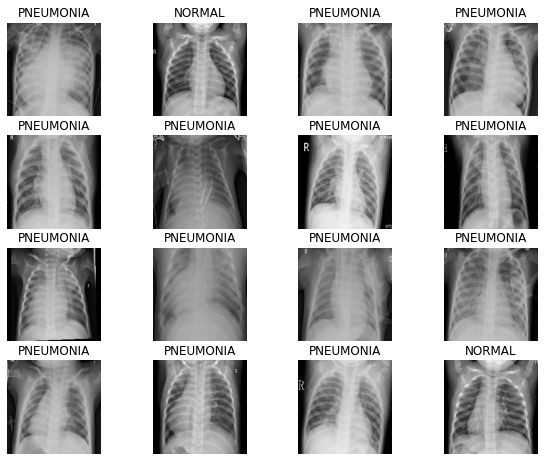

In [28]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [29]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [30]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_9 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_10 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 128)     

In [32]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 60s 195ms/step - loss: 0.4220 - accuracy: 0.7909 - precision: 0.9465 - recall: 0.7622 - val_loss: 0.6677 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 193ms/step - loss: 0.2548 - accuracy: 0.8985 - precision: 0.9725 - recall: 0.8885 - val_loss: 1.2087 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 51s 196ms/step - loss: 0.2170 - accuracy: 0.9128 - precision: 0.9774 - recall: 0.9038 - val_loss: 0.2464 - val_accuracy: 0.8904 - val_precision: 0.8702 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1955 - accuracy: 0.9241 - precision: 0.9761 - recall: 0.9204 - val_loss: 0.0819 - val_accuracy: 0.9760 - val_precision: 0.9756 - val_recall: 0.9922
Epoch 5/25
261/261 [==============================] - 52s 199ms/step - loss: 0.1846 - accura

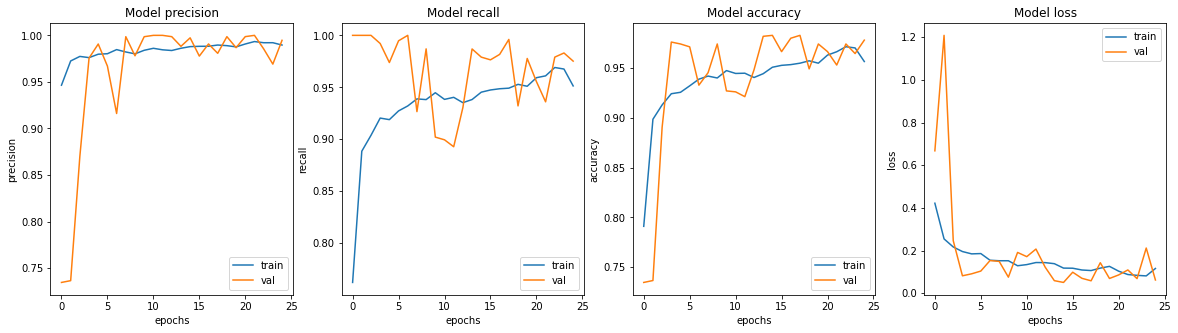

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 105ms/step - loss: 0.6025 - accuracy: 0.8093 - precision: 0.7694 - recall: 0.9923
Loss: 0.6025243997573853,
Accuracy: 0.8092948794364929,
Precision: 0.7693836688995361,
Recall: 0.9923076629638672


## 2. Augmentation : Random B/S, Regularization : BatchNorm, Dropout

In [35]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [36]:
def augment(image,label):
    
     # Random B/S changes
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check    
    
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [37]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

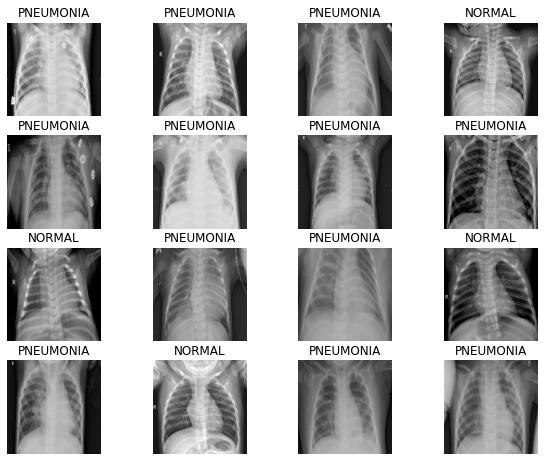

In [38]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [39]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [40]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [41]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_16 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_17 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_18 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_10 (Dropout)         (None, 11, 11, 128)     

In [42]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 61s 196ms/step - loss: 0.4559 - accuracy: 0.7792 - precision: 0.9368 - recall: 0.7540 - val_loss: 0.6757 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 51s 194ms/step - loss: 0.2356 - accuracy: 0.9126 - precision: 0.9741 - recall: 0.9067 - val_loss: 1.1828 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 51s 196ms/step - loss: 0.2193 - accuracy: 0.9191 - precision: 0.9746 - recall: 0.9151 - val_loss: 0.7865 - val_accuracy: 0.7433 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1976 - accuracy: 0.9258 - precision: 0.9781 - recall: 0.9206 - val_loss: 0.1466 - val_accuracy: 0.9500 - val_precision: 0.9945 - val_recall: 0.9373
Epoch 5/25
261/261 [==============================] - 52s 198ms/step - loss: 0.1477 - accura

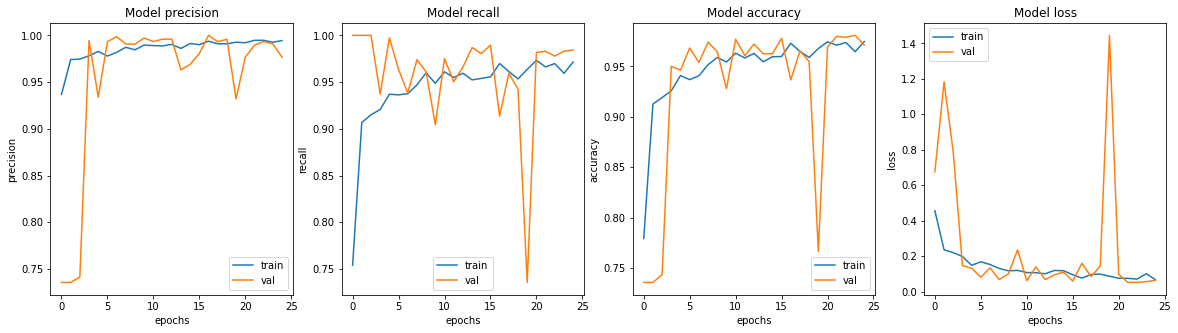

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [44]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 1.6676 - accuracy: 0.7212 - precision: 0.6915 - recall: 1.0000
Loss: 1.667588233947754,
Accuracy: 0.7211538553237915,
Precision: 0.6914893388748169,
Recall: 1.0


### 3.  Augmentation : Random Resize / crop, Regularization : BatchNorm, Dropout

In [45]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [46]:
def augment(image,label):
    
    # random resize and random crop back to expected size
    random_scale_factor = tf.random.uniform([1], minval=1., maxval=1.4, dtype=tf.float32)
    scaled_height = tf.cast(tf.cast(input_shape[0], tf.float32) * random_scale_factor, tf.int32)
    scaled_width = tf.cast(tf.cast(input_shape[1], tf.float32) * random_scale_factor, tf.int32)       
    scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))

    image = tf.image.resize(image, scaled_shape)
    image = tf.image.random_crop(image, input_shape)
    
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [47]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

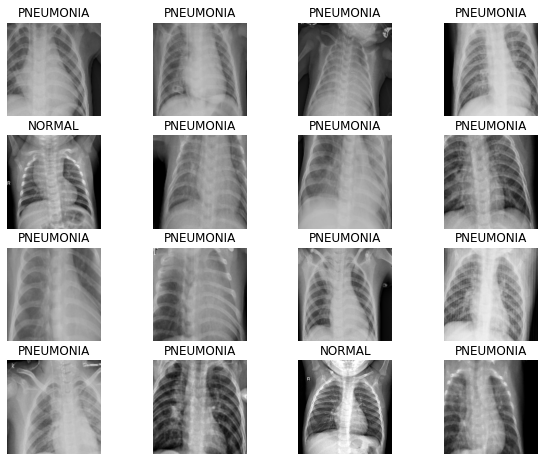

In [48]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [49]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [50]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [51]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_24 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_25 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_26 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_15 (Dropout)         (None, 11, 11, 128)     

In [52]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 59s 193ms/step - loss: 0.4506 - accuracy: 0.7878 - precision: 0.9447 - recall: 0.7591 - val_loss: 0.6192 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 191ms/step - loss: 0.3377 - accuracy: 0.8611 - precision: 0.9530 - recall: 0.8555 - val_loss: 1.0592 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2899 - accuracy: 0.8772 - precision: 0.9612 - recall: 0.8698 - val_loss: 0.3063 - val_accuracy: 0.8394 - val_precision: 0.8227 - val_recall: 0.9961
Epoch 4/25
261/261 [==============================] - 50s 192ms/step - loss: 0.2521 - accuracy: 0.8961 - precision: 0.9708 - recall: 0.8871 - val_loss: 0.3677 - val_accuracy: 0.8538 - val_precision: 0.9811 - val_recall: 0.8168
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.2531 - accura

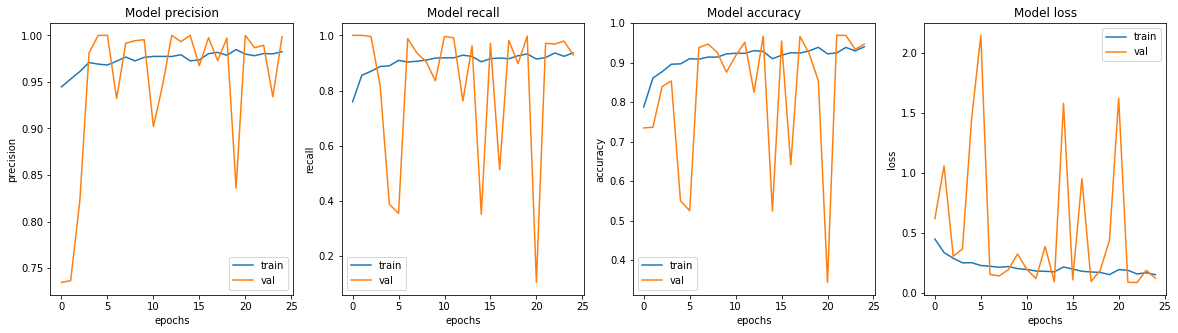

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [54]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 105ms/step - loss: 0.2123 - accuracy: 0.9231 - precision: 0.9111 - recall: 0.9718
Loss: 0.21232937276363373,
Accuracy: 0.9230769276618958,
Precision: 0.911057710647583,
Recall: 0.971794843673706


## 4. Augmentation : Random Horizontal Flips, Random B/S, Regularization : BatchNorm, Dropout

In [55]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [56]:
def augment(image,label):
    
    # Random Horizontal Flip changes
    image = tf.image.random_flip_left_right(image) 
    
    # Random B/S changes
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check    
    
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [57]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

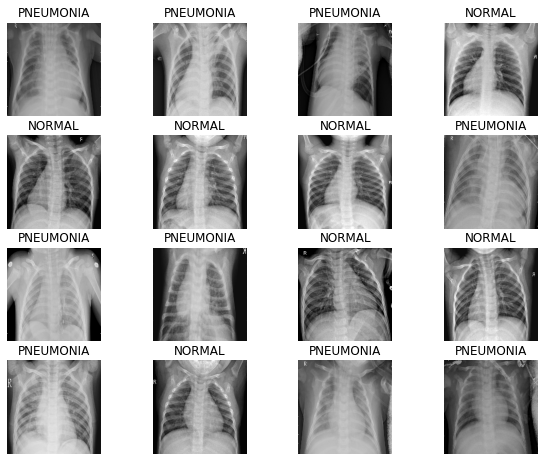

In [58]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [59]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [60]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [61]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_32 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_33 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_34 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_20 (Dropout)         (None, 11, 11, 128)     

In [62]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 60s 194ms/step - loss: 0.4255 - accuracy: 0.7902 - precision: 0.9467 - recall: 0.7606 - val_loss: 0.6664 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 51s 194ms/step - loss: 0.2365 - accuracy: 0.9076 - precision: 0.9749 - recall: 0.8990 - val_loss: 1.2590 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 193ms/step - loss: 0.2106 - accuracy: 0.9207 - precision: 0.9747 - recall: 0.9173 - val_loss: 0.6887 - val_accuracy: 0.7529 - val_precision: 0.7483 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 194ms/step - loss: 0.2130 - accuracy: 0.9186 - precision: 0.9723 - recall: 0.9166 - val_loss: 0.5596 - val_accuracy: 0.8115 - val_precision: 1.0000 - val_recall: 0.7435
Epoch 5/25
261/261 [==============================] - 52s 198ms/step - loss: 0.1963 - accura

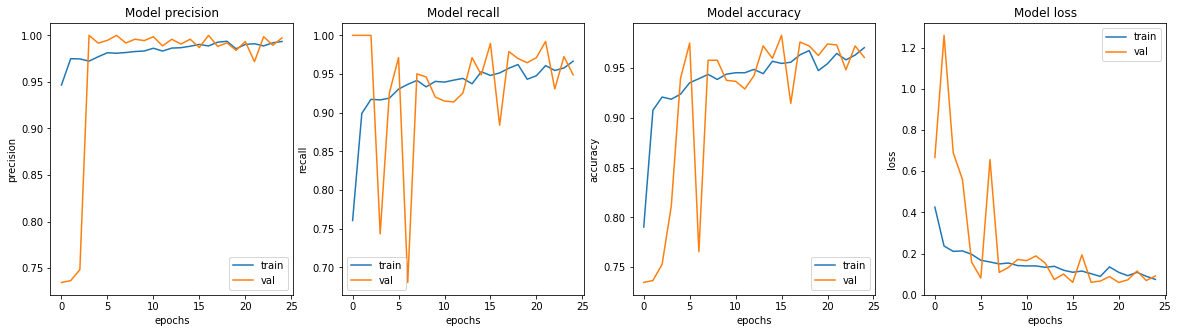

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [64]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.6711 - accuracy: 0.8494 - precision: 0.8190 - recall: 0.9744
Loss: 0.6710954308509827,
Accuracy: 0.8493589758872986,
Precision: 0.818965494632721,
Recall: 0.9743589758872986


## 5. Augmentation : Random Horizontal Flips, Random Resize / crop, Regularization : BatchNorm, Dropout

In [65]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [66]:
def augment(image,label):
    
    # Random Horizontal Flip changes
    image = tf.image.random_flip_left_right(image) 
    
    # random resize and random crop back to expected size
    random_scale_factor = tf.random.uniform([1], minval=1., maxval=1.4, dtype=tf.float32)
    scaled_height = tf.cast(tf.cast(input_shape[0], tf.float32) * random_scale_factor, tf.int32)
    scaled_width = tf.cast(tf.cast(input_shape[1], tf.float32) * random_scale_factor, tf.int32)       
    scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))

    image = tf.image.resize(image, scaled_shape)
    image = tf.image.random_crop(image, input_shape)   
    
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [67]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

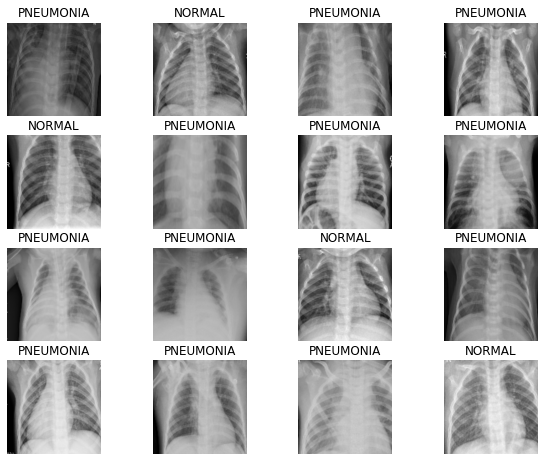

In [68]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [69]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [70]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [71]:
model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_40 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_41 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_42 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_25 (Dropout)         (None, 11, 11, 128)     

In [72]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 59s 189ms/step - loss: 0.4940 - accuracy: 0.7574 - precision: 0.9392 - recall: 0.7206 - val_loss: 0.6133 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 191ms/step - loss: 0.3797 - accuracy: 0.8331 - precision: 0.9476 - recall: 0.8210 - val_loss: 0.9575 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.3159 - accuracy: 0.8669 - precision: 0.9590 - recall: 0.8577 - val_loss: 0.5549 - val_accuracy: 0.7385 - val_precision: 0.7377 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 191ms/step - loss: 0.3149 - accuracy: 0.8657 - precision: 0.9636 - recall: 0.8516 - val_loss: 0.6748 - val_accuracy: 0.7635 - val_precision: 1.0000 - val_recall: 0.6789
Epoch 5/25
261/261 [==============================] - 50s 194ms/step - loss: 0.2872 - accura

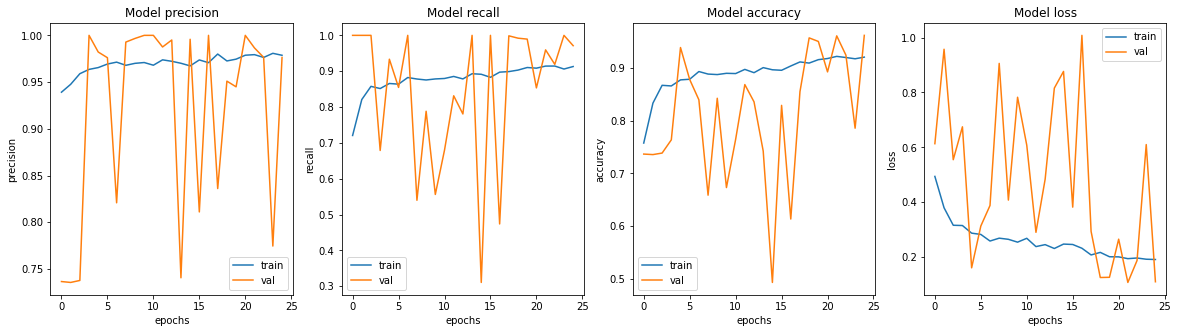

In [73]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [74]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 0.4482 - accuracy: 0.8349 - precision: 0.7996 - recall: 0.9821
Loss: 0.4482031464576721,
Accuracy: 0.8349359035491943,
Precision: 0.7995824813842773,
Recall: 0.9820512533187866


### 6. Augmentation : Random B/S, Random Resize / crop, Regularization : BatchNorm, Dropout

In [75]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [76]:
def augment(image,label):
    
    # Random B/S changes
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check   
    
    # random resize and random crop back to expected size
    random_scale_factor = tf.random.uniform([1], minval=1., maxval=1.4, dtype=tf.float32)
    scaled_height = tf.cast(tf.cast(input_shape[0], tf.float32) * random_scale_factor, tf.int32)
    scaled_width = tf.cast(tf.cast(input_shape[1], tf.float32) * random_scale_factor, tf.int32)       
    scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))

    image = tf.image.resize(image, scaled_shape)
    image = tf.image.random_crop(image, input_shape)   
    
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [77]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

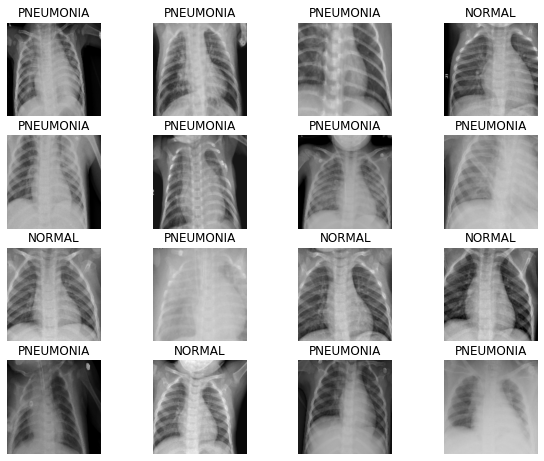

In [78]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [79]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [80]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [81]:
model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_48 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_49 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_50 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_30 (Dropout)         (None, 11, 11, 128)     

In [82]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 61s 199ms/step - loss: 0.5129 - accuracy: 0.7340 - precision: 0.9265 - recall: 0.6978 - val_loss: 0.6024 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 193ms/step - loss: 0.3504 - accuracy: 0.8434 - precision: 0.9564 - recall: 0.8271 - val_loss: 1.0136 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 51s 196ms/step - loss: 0.2841 - accuracy: 0.8834 - precision: 0.9629 - recall: 0.8770 - val_loss: 0.7651 - val_accuracy: 0.7500 - val_precision: 0.7458 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 52s 199ms/step - loss: 0.2757 - accuracy: 0.8855 - precision: 0.9640 - recall: 0.8789 - val_loss: 0.2176 - val_accuracy: 0.9115 - val_precision: 0.9941 - val_recall: 0.8850
Epoch 5/25
261/261 [==============================] - 53s 205ms/step - loss: 0.2483 - accura

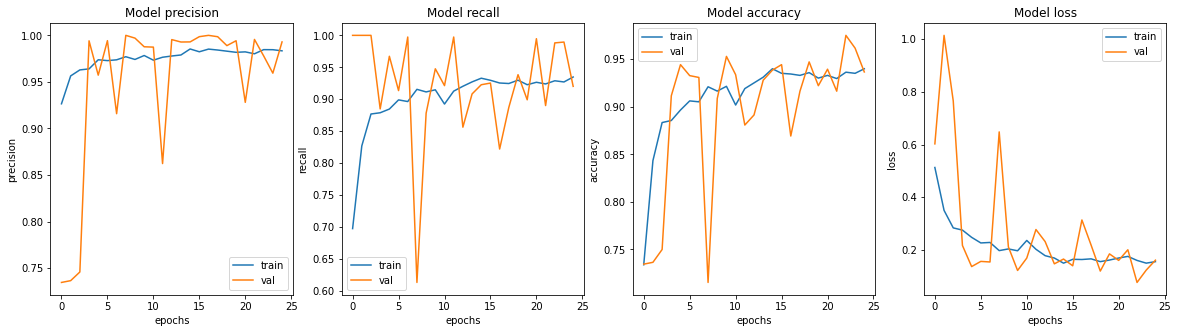

In [83]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [84]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.2425 - accuracy: 0.9151 - precision: 0.9181 - recall: 0.9487
Loss: 0.24252383410930634,
Accuracy: 0.9150640964508057,
Precision: 0.9181141257286072,
Recall: 0.9487179517745972


## [결론 및 회고]

이번 프로젝트에서는 기존의 폐렴 진단 모델의 성능을 높이는 방법을 배울 수 있었습니다. 저는 좌우반전, 색밝기 조정, 사이즈 크롭 등의 다양한 방법으로 데이터를 변형하여 학습 데이터를 증대시켰습니다. 

다양한 augmentation 방법들의 조합으로 데이터를 생성한 후 학습시켰고, accuracy나 recall을 높일 수 있었습니다.     

다양한 augmentation을 부여해본 결과,    

Augmentation : Random Resize / crop, Regularization : BatchNorm, Dropout을 부여해준 3번 모델이 가장 성능이 좋았습니다. 
그다음으로 Augmentation : Random B/S, Random Resize / crop, Regularization : BatchNorm, Dropou을 부여한 6번 모델이 좋았습니다.

하지만 이상한점은, 처음 3번 모델을 테스트 했을때는 성능이 좋지 않았지만, 갑자기 6번보다 성능이 좋게 나왔습니다.

결과적으로, 
epoch = 25만 주었음에도 

3번 모델경우 
- Loss: 0.21232937276363373,
- Accuracy: 0.9230769276618958,
- Precision: 0.911057710647583,
- Recall: 0.971794843673706

6번 모델경우 
- Loss: 0.24252383410930634,
- Accuracy: 0.9150640964508057,
- Precision: 0.9181141257286072,
- Recall: 0.9487179517745972

라는 높은 성능을 보였고 그래프를 통해 과적합도 어느 정도 잘 잡혔음을 볼 수 있었습니다.  결론 - 92% :)


프로젝트를 수행하면서 다양한 augmentation에 대해 알 수 있었습니다. 막연히 데이터가 증가하면 무조건 accuracy도 높아질거라 생각했는데, 

어떻게 처리를 해주느냐에 따라 모델 성능이 좋아지기도 하고 나빠지기도 할 수 있다는 것을 직접 확인할 수 있었습니다. 

또한 가장 성능이 좋았던 augmentation을 가지고 cnn 모델을 변경시키기도 했습니다.